In [1]:
import pandas as pd, numpy as np, requests, zipfile, io, warnings
from scipy import stats
warnings.filterwarnings("ignore")

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
r = requests.get(url, timeout=60)
zf = zipfile.ZipFile(io.BytesIO(r.content))
with zf.open("student-mat.csv") as f:
    student = pd.read_csv(f, sep=";")

student.shape


(395, 33)

In [2]:
def spearman_brown(r):
    if pd.isna(r): return np.nan
    return (2*r)/(1+r)

def spearman_alpha(df_items):
    R = df_items.rank(method="average").corr(method="spearman")
    k = R.shape[0]
    if k < 2: return np.nan
    return (k/(k-1))*(1 - np.trace(R.values)/R.values.sum())

def alpha_if_dropped_spearman(df_items):
    return pd.Series({
        c: spearman_alpha(df_items.drop(columns=[c])) for c in df_items.columns
    })


### Analysis: Socializing Risk Scale

* **Action:** A three-item scale for 'socializing risk' is tested by combining weekday alcohol use (`Dalc`), weekend alcohol use (`Walc`), and frequency of going out (`goout`). The scale's internal consistency is measured using Ordinal Alpha.
* **Result:** The analysis yields an **Ordinal Alpha of 0.693**, which is borderline acceptable. The item-drop diagnostic is revealing: if the `goout` item is removed, the alpha of the remaining two-item scale **improves to 0.780**.
* **Interpretation:** The `goout` item weakens the scale's internal consistency, suggesting it may measure a slightly different construct than alcohol consumption alone. A more reliable scale for alcohol use would consist of only the `Dalc` and `Walc` items.

In [10]:
risk2 = student[["Dalc","Walc"]].copy()
r_s = risk2["Dalc"].corr(risk2["Walc"], method="spearman")
rho_sb = spearman_brown(r_s)
student["alcohol_involvement"] = risk2.mean(axis=1)

print(f"Spearman r(Dalc,Walc) = {r_s:.3f}")
print(f"Spearman–Brown reliability = {rho_sb:.3f}")
print(f"M={student['alcohol_involvement'].mean():.2f}, SD={student['alcohol_involvement'].std():.2f}")


Spearman r(Dalc,Walc) = 0.640
Spearman–Brown reliability = 0.780
M=1.89, SD=0.99


In [11]:
vals = []
x, y = student["Dalc"], student["Walc"]
n = len(student)
for _ in range(2000):
    idx = np.random.randint(0, n, n)
    vals.append(spearman_brown(x.iloc[idx].corr(y.iloc[idx], method="spearman")))
ci_lo, ci_hi = np.percentile(vals, [2.5, 97.5])
print(f"Spearman–Brown 95% CI: {ci_lo:.3f}–{ci_hi:.3f}")


Spearman–Brown 95% CI: 0.733–0.823


In [12]:
risk3 = student[["Dalc","Walc","goout"]].copy()
alpha_ord = spearman_alpha(risk3)
drop_ord = alpha_if_dropped_spearman(risk3).round(3)
student["socializing_risk"] = risk3.mean(axis=1)

print(f"Ordinal alpha = {alpha_ord:.3f}")
print("Alpha if dropped:")
print(drop_ord)
print(f"M={student['socializing_risk'].mean():.2f}, SD={student['socializing_risk'].std():.2f}")


Ordinal alpha = 0.693
Alpha if dropped:
Dalc     0.565
Walc     0.407
goout    0.780
dtype: float64
M=2.29, SD=0.88


In [15]:
out = {
    "alcohol_r_s": r_s,
    "alcohol_sb": rho_sb,
    "alcohol_ci_lo": ci_lo,
    "alcohol_ci_hi": ci_hi,
    "socializing_alpha_ord": alpha_ord,
    "family_sb": rho_f,
    "academic_sb": rho_a
}
pd.DataFrame([out]).to_csv("scale_summary.csv", index=False)
student[["alcohol_involvement","socializing_risk"]].to_csv("scale_scores.csv", index=False)
print("Saved: scale_summary.csv, scale_scores.csv")


Saved: scale_summary.csv, scale_scores.csv


### Analysis: Grouped Reliability by Sex

* **Action:** The reliability of the two-item `alcohol_involvement` scale is calculated separately for male and female students to check for group differences.
* **Result:** The scale is more reliable for males (**ρ_SB = 0.814**) than for females (**ρ_SB = 0.705**).
* **Interpretation:** While the scale is acceptable for both groups, the consistency between weekday and weekend drinking patterns is notably stronger among the male students in this sample.

In [16]:
def group_sb(df, group_col):
    rows = []
    for g, d in df.groupby(group_col):
        r = d['Dalc'].corr(d['Walc'], method='spearman')
        sb = (2*r)/(1+r) if pd.notna(r) else np.nan
        rows.append({group_col: g, 'rho_SB': sb, 'n': len(d)})
    return pd.DataFrame(rows)

group_results = group_sb(student, 'sex')
print(group_results)


  sex    rho_SB    n
0   F  0.705025  208
1   M  0.814338  187


### Visualizations

* **Action:** The final cells visualize the key findings. Plots include a density plot for `alcohol_involvement`, a boxplot for `socializing_risk`, and a correlation heatmap of all tested items.
* **Interpretation:** The visualizations confirm the numerical results. The density and boxplots clearly show that males tend to have higher scores on the alcohol and socializing scales. The heatmap provides an excellent overview of the item relationships, visually confirming the strong correlation between `Dalc` and `Walc` and the weak correlations for the rejected scales.

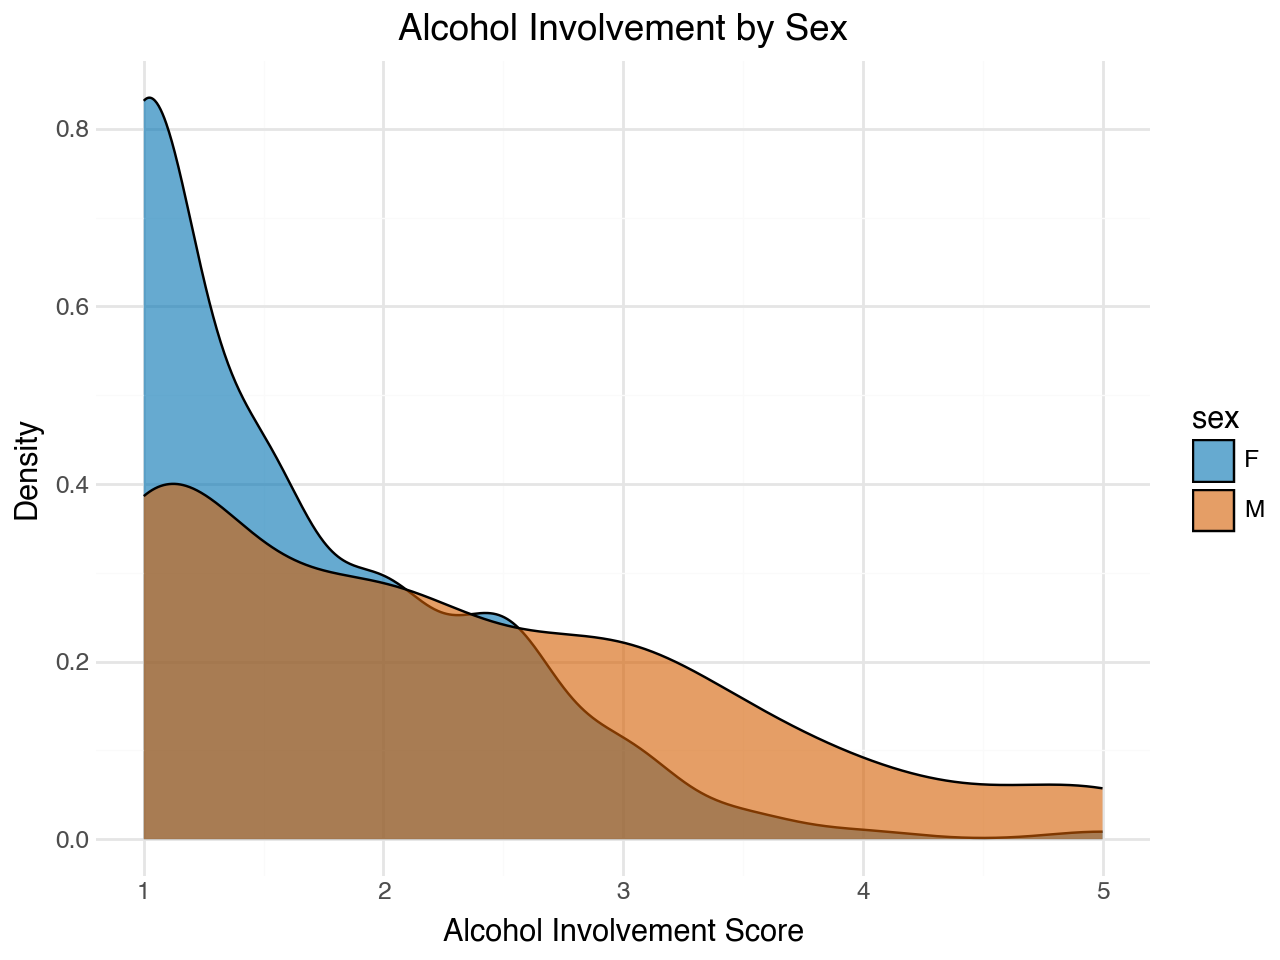

In [ ]:
from plotnine import *


color_blind_palette = ["#0072B2", "#D55E00"]  

(ggplot(student, aes(x="alcohol_involvement", fill="sex"))
 + geom_density(alpha=0.6, color="black")
 + scale_fill_manual(values=color_blind_palette)
 + labs(title="Alcohol Involvement by Sex",
        x="Alcohol Involvement Score",
        y="Density")
 + theme_minimal()
 + theme(legend_position="right")
)


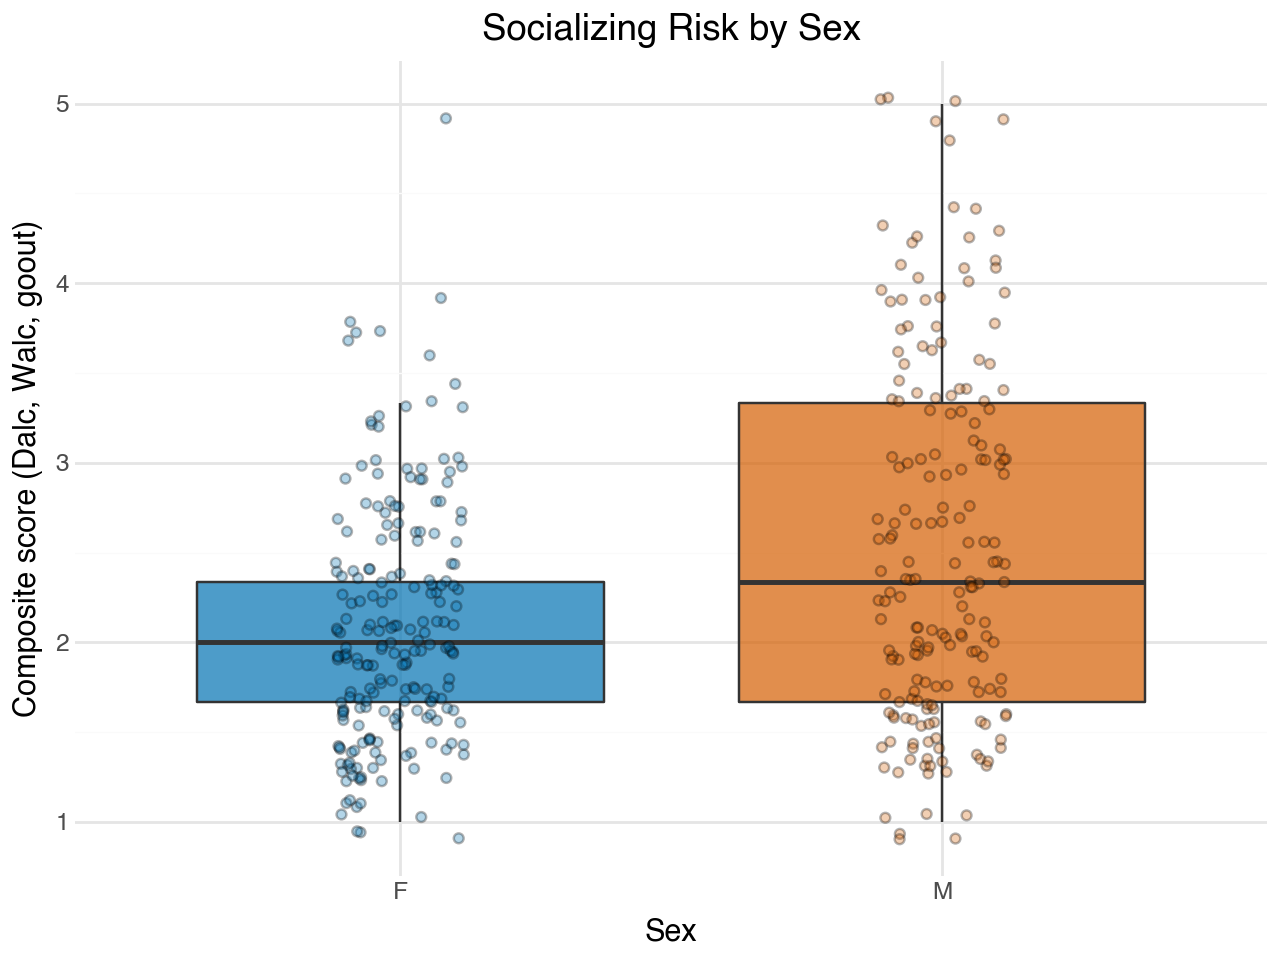

In [20]:
(
    ggplot(student, aes(x="sex", y="socializing_risk", fill="sex"))
    + geom_boxplot(alpha=0.7, outlier_alpha=0)
    + geom_jitter(width=0.12, alpha=0.3, color="black")
    + scale_fill_manual(values=color_blind_palette)
    + labs(
        title="Socializing Risk by Sex",
        x="Sex",
        y="Composite score (Dalc, Walc, goout)"
    )
    + theme_minimal()
    + theme(legend_position="none")
)


#### Visualization: Item–Item Correlation Heatmap

This heatmap shows the Spearman correlations among items tested as potential scale components.  
(See the [Aside: Reliability of Other Composites](#aside-reliability-of-other-composites) section for more detail.)

Key takeaways:

- The bright square at the intersection of **Dalc** and **Walc** confirms their strong correlation, which is why they form a reliable two-item alcohol scale.  
- The very dark squares for **famrel–health** and **studytime–failures** show near-zero correlation, visually explaining why those pairs could not be combined into reliable scales.  


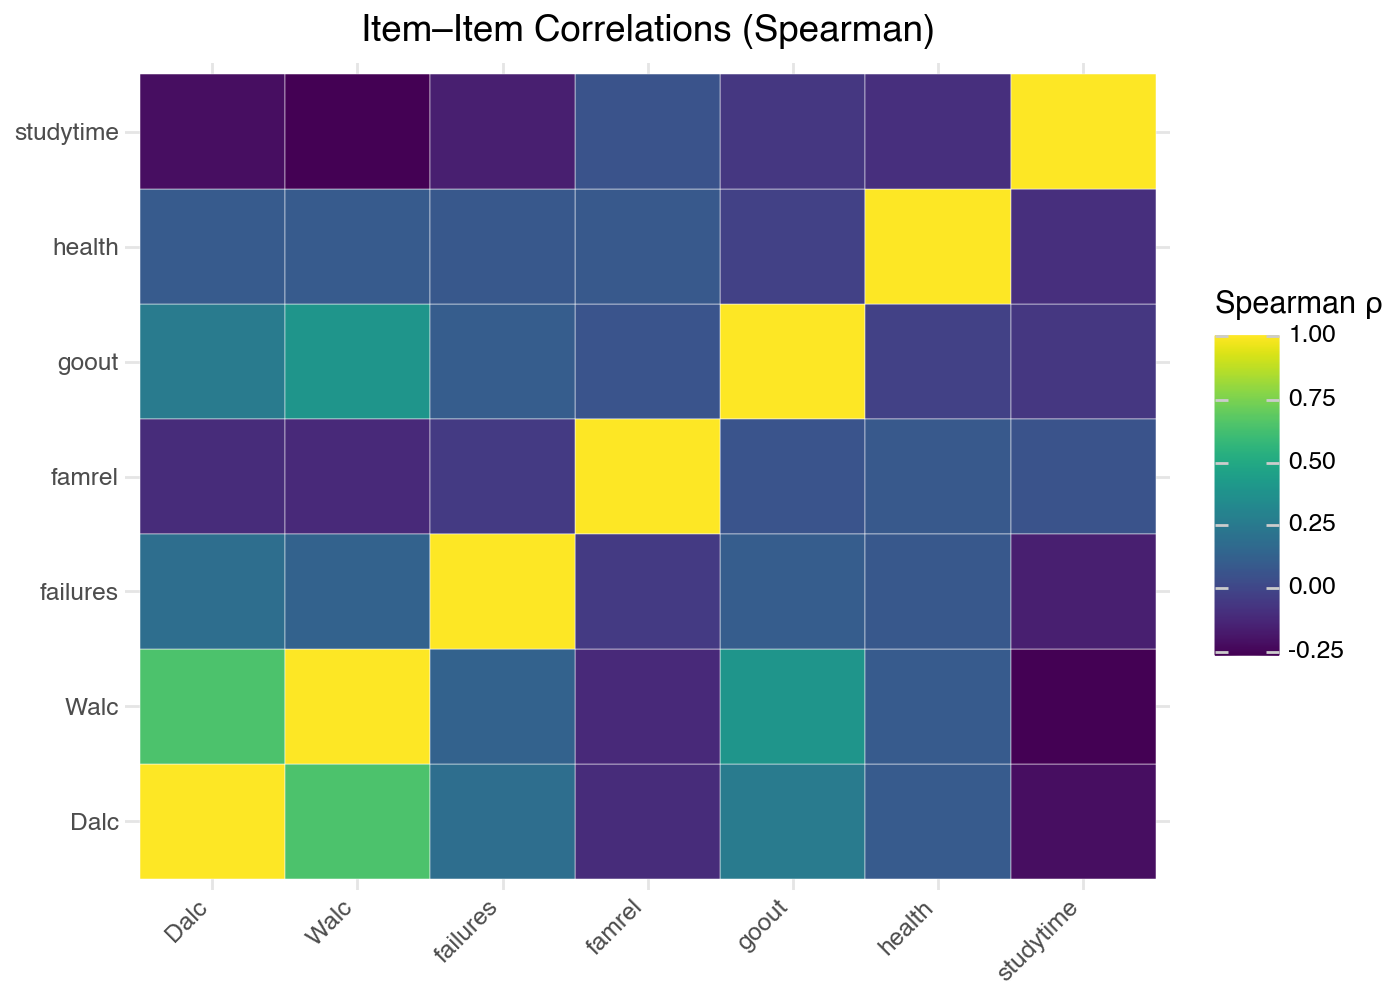

In [21]:
items = ["Dalc","Walc","goout","famrel","health","studytime","failures"]
R = student[items].corr(method="spearman").reset_index().melt(id_vars="index")
R.columns = ["item_x", "item_y", "rho"]

(
    ggplot(R, aes("item_x", "item_y", fill="rho"))
    + geom_tile(color="white")
    + scale_fill_cmap(name="Spearman ρ")
    + theme_minimal()
    + theme(
        axis_text_x=element_text(rotation=45, ha="right"),
        figure_size=(7,5)
    )
    + labs(
        title="Item–Item Correlations (Spearman)",
        x="", y=""
    )
)


### Aside: Reliability of Other Composites

For comparison, I tested additional composites beyond alcohol use:

* **Social support** (famrel + famsup + schoolsup) → Ordinal α = 0.060  
* **Academic engagement** (studytime + low_failures) → Spearman–Brown ρ = 0.272  
* **Family functioning** (famrel + health) → Spearman–Brown ρ = 0.157  

All three showed **very poor reliability**. The items mixed binary and short ordinal responses and weren’t written to measure the same latent construct, so they didn’t “hang together.”  

This illustrates why validated psychometric instruments are necessary in program evaluation.


In [27]:

soc = pd.DataFrame({
    "famrel": student["famrel"],
    "famsup": (student["famsup"] == "yes").astype(int),
    "schoolsup": (student["schoolsup"] == "yes").astype(int)
})
alpha_social = spearman_alpha(soc)


acad = pd.DataFrame({
    "studytime": student["studytime"],
    "low_failures": 4 - student["failures"]  # reverse so higher = better
})
r_acad = acad["studytime"].corr(acad["low_failures"], method="spearman")
sb_acad = spearman_brown(r_acad)


fam = student[["famrel","health"]].copy()
r_fam = fam["famrel"].corr(fam["health"], method="spearman")
sb_fam = spearman_brown(r_fam)

print(f"Social support (famrel + famsup + schoolsup) → Ordinal alpha = {alpha_social:.3f}")
print(f"Academic engagement (studytime + low_failures) → Spearman–Brown = {sb_acad:.3f}")
print(f"Family functioning (famrel + health) → Spearman–Brown = {sb_fam:.3f}")


Social support (famrel + famsup + schoolsup) → Ordinal alpha = 0.060
Academic engagement (studytime + low_failures) → Spearman–Brown = 0.272
Family functioning (famrel + health) → Spearman–Brown = 0.157
